## ATP ranking stats

 Importing the required libraries.

In [93]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data

We're going to download our data from [ATP World Tour tennis data](https://datahub.io/sports-data/atp-world-tour-tennis-data/r/rankings_1973-2017.csv)

In [94]:
!mkdir -p data/
if not os.path.exists('data/rankings_1973-2017.csv'):
    !curl -sSL -o data/rankings_1973-2017.csv https://datahub.io/sports-data/atp-world-tour-tennis-data/r/rankings_1973-2017.csv

In [95]:
atp_rankings = pd.read_csv('data/rankings_1973-2017.csv', dtype={'week_title': object, 'week_year': int, 'week_month': int, 'week_day': int, 'rank_text': object, 'rank_number': int, 'move_position': float, 'move_direction': object, 'player_age': float, 'ranking_points': int, 'tourneys_played': int, 'player_url': object, 'player_slug': object, 'player_id': object})

Let's take a look at the size of our data set. The shape attribute gives us the number of rows and the number of columns in the data that we loaded.

In [96]:
atp_rankings.shape

(2694539, 14)

We can also look at what type of data each column contains.

In [97]:
atp_rankings.dtypes

week_title          object
week_year            int64
week_month           int64
week_day             int64
rank_text           object
rank_number          int64
move_positions     float64
move_direction      object
player_age         float64
ranking_points       int64
tourneys_played      int64
player_url          object
player_slug         object
player_id           object
dtype: object

Since we will not use the whole data set lets subset our data by the columns we will need. We want to get out the week_year, week_month, week_day, rank_number and player_age, and save this into a new variable.

In [98]:
rankings_subset = atp_rankings[['week_year', 'week_month', 'week_day', 'rank_number', 'player_age', 'player_slug']]

Let's take a look at how much missing data is in our data set. We can use the isnull method from numpy to count how many values in our dataset are missing. We can also look at specific columns of our data.

In [99]:
print('The amount of missing data:',(np.count_nonzero(rankings_subset.isnull())))
print('The amount of missing data in the years column:',(np.count_nonzero(rankings_subset['week_year'].isnull())))
print('The amount of missing data in the rankings column:', (np.count_nonzero(rankings_subset['rank_number'].isnull())))
print('The amount of missing data in the players age column:', (np.count_nonzero(rankings_subset['player_age'].isnull())))

The amount of missing data: 214559
The amount of missing data in the years column: 0
The amount of missing data in the rankings column: 0
The amount of missing data in the players age column: 214559


Since all of the missing data is in the player_age column we will need to keep that in mind once we start to analyse the data.

In the tennis ranking system each weekly set of rankings is a list of the point totals earned by players at tournaments in the last 52 weeks. At the end of the year, the rolling rankings catch up to the season so that only the events of the current year are included. That is why the last rankings from each year are the best evaluators of a player’s performance from that calendar year. So to find the year-end rankings we need to sort through the data to find the last set of rankings for each year.

In [100]:
def find_all_years(df):
    all_years = df['week_year'].unique()
    all_years.sort()
    all_years_list = all_years.tolist()
    return all_years_list

def find_last_date(df, year):
    search_year = df[df['week_year'] == year]
    search_month = sorted(search_year['week_month'].unique())[-1]
    search_year_search_month = search_year[search_year['week_month'] == search_month]
    search_day = sorted(search_year_search_month['week_day'].unique())[-1]
    return search_month, search_day

def year_end_top_100(df, year):
    last_month, last_day = find_last_date(df, year)
    search_year = df[df['week_year'] == year]
    year_end_month = search_year[search_year['week_month'] == last_month]
    year_end_day = year_end_month[year_end_month['week_day'] == last_day]
    sorted_top = year_end_day.sort_values(by=['rank_number'])
    top_100 = sorted_top[:100]
    return top_100

Now let's look what years' rankings are in the data set.

In [101]:
print(find_all_years(rankings_subset))

[1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


Now let's see if we can find the five highest ranked players from 2017.

In [102]:
year_end_top_100(rankings_subset, 2017).head()

,week_year,week_month,week_day,rank_number,player_age,player_slug
0,2017,11,20,1,31.0,rafael-nadal
1,2017,11,20,2,36.0,roger-federer
2,2017,11,20,3,26.0,grigor-dimitrov
3,2017,11,20,4,20.0,alexander-zverev
4,2017,11,20,5,24.0,dominic-thiem


From our data set we are going to take out the the top 100 from each year from the last rankings of that year and join them together into one data set using the concat method from pandas.

In [103]:
appended_df = []
for year in find_all_years(rankings_subset):
    subset_year = year_end_top_100(rankings_subset, year)
    appended_df.append(subset_year)
appended_df = pd.concat(appended_df)

When we look at the new dataset we see that most of the data from 1980, 1981 and 1982 is missing, from 1983 half of the data is missing and also one entry is missing from 1976. From all the other years we have a complete year-end top 100.

In [104]:
appended_df.groupby('week_year').size()

week_year
1973    100
1974    100
1975    100
1976    100
1977    100
1978    100
1979    100
1980      2
1981      1
1982      1
1983     50
1984    100
1985    100
1986    100
1987    100
1988    100
1989    100
1990    100
1991    100
1992    100
1993    100
1994    100
1995    100
1996    100
1997    100
1998    100
1999    100
2000    100
2001    100
2002    100
2003    100
2004    100
2005    100
2006    100
2007    100
2008    100
2009    100
2010    100
2011    100
2012    100
2013    100
2014    100
2015    100
2016    100
2017    100
dtype: int64

From that data frame we will break down each calculation by year and look at the average age of players. The groupby statement takes the week_year column and splits our data by unique values of that column. Then it will calculate the mean of each subset (excluding NaN values) and return a single data frame.

In [105]:
average_age = appended_df.groupby('week_year')['player_age'].agg(average_age=pd.NamedAgg(column='average_age', aggfunc='mean'), youngest=pd.NamedAgg(column='youngest', aggfunc='min'), oldest=pd.NamedAgg(column='oldest', aggfunc='max'))
average_age.head(n=10)

,average_age,youngest,oldest
week_year,,,
1973,26.450000,17.0,39.0
1974,26.760000,17.0,40.0
1975,26.620000,18.0,41.0
1976,26.949495,19.0,42.0
1977,27.010000,12.0,43.0
1978,26.190000,18.0,44.0
1979,26.080000,19.0,38.0
1980,28.000000,28.0,28.0
1981,21.000000,21.0,21.0


As we do not want to include data that is based on incomplete data, we use the .drop method from pandas to remove data from from 1980, 1981 and 1982.

In [106]:
clean_data = average_age.drop(average_age.index[[7,8,9]])
clean_data.head(n=10)

,average_age,youngest,oldest
week_year,,,
1973,26.450000,17.0,39.0
1974,26.760000,17.0,40.0
1975,26.620000,18.0,41.0
1976,26.949495,19.0,42.0
1977,27.010000,12.0,43.0
1978,26.190000,18.0,44.0
1979,26.080000,19.0,38.0
1983,25.120000,18.0,32.0
1984,24.610000,17.0,33.0


Now lets take the above data and use Python's plotting library matplotlib to plot it.

Text(0, 0.5, 'Age')

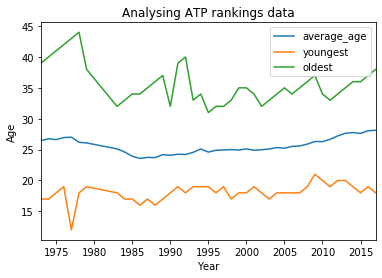

In [107]:
data_graph = clean_data.plot()
data_graph.set_title('Analysing ATP rankings data')
data_graph.set_xlabel('Year')
data_graph.set_ylabel('Age')

We can see that the average age of top tennis players has been steadily increasing since the late 1980s and has never been as high as it is at the moment.

Text(17.200000000000003, 0.5, 'Age')

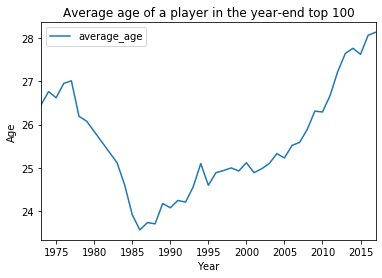

In [108]:
data1 = clean_data.plot(y='average_age')
data1.set_title('Average age of a player in the year-end top 100')
data1.set_xlabel('Year')
data1.set_ylabel('Age')
data_graph.set_ylabel('Age')

We can see that the average age of top tennis players has been steadily increasing since the late 1980s and has never been as high as it is at the moment.

Text(0, 0.5, 'Age')

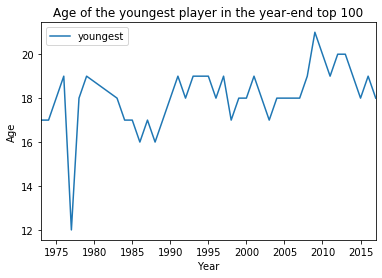

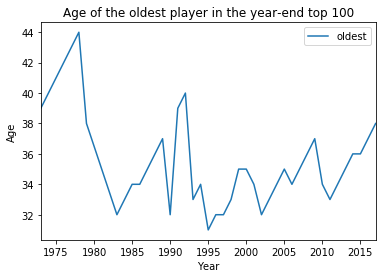

In [109]:
data2 = clean_data.plot(y='youngest')
data2.set_title('Age of the youngest player in the year-end top 100')
data2.set_xlabel('Year')
data2.set_ylabel('Age')
data3 = clean_data.plot(y='oldest')
data3.set_title('Age of the oldest player in the year-end top 100')
data3.set_xlabel('Year')
data3.set_ylabel('Age')

When we look at the youngest players graph we see that there was a very young player between 1975 and 1980.

In [110]:
average_age = appended_df.groupby('week_year')['player_age'].agg(youngest=pd.NamedAgg(column='youngest', aggfunc='min'))
average_age.head(n=10)

,youngest
week_year,
1973,17.0
1974,17.0
1975,18.0
1976,19.0
1977,12.0
1978,18.0
1979,19.0
1980,28.0
1981,21.0


When we look on the ATP website at rankings from 1977 we find a player named Danny Granot who is listed as born in 1965 but actualy competed between 1992 and 1997. So it must be an error and instead the youngest player in the top 100 of that year was John McEnroe who was 18 years old at the time.